In [1]:
import pymodel

In [2]:
import statsmodels
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
import ml_metrics as metrics
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.tsa.holtwinters
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import median_absolute_error
from sklearn.utils import check_array
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import datetime
%matplotlib inline
# plt.style.use('Solarize_Light2')

In [3]:
import seaborn as sns

In [4]:
sns.set_style()

In [5]:
def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  
def MdAPE(y_true, y_pred): 
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

def sMAPE(actual, predicted):
    return 100 * np.mean(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted))))

def sMdAPE(actual, predicted):
    return 100 * np.median(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted))))

def RMSPE(actual, predicted):
    return 100 * np.sqrt(np.mean(np.square((actual - predicted)/actual)))

def RMdSPE(actual: np.ndarray, predicted: np.ndarray):
    return 100 * np.sqrt(np.median(np.square((actual - predicted)/actual))) 

In [6]:
def predict_ours(train, test, yearly_seasonality=0., weekly_seasonality=0., daily_seasonality=0., 
                 n_changepoints_init=25, seasonality_prior_scale_init = 10.0):
    model = pymodel.PyModel()
    model.fit(train.index.values, train['data'].values, ys_order=yearly_seasonality, ws_order=weekly_seasonality, 
              ds_order=daily_seasonality, n_changepoints_init=n_changepoints_init,
             seasonality_prior_scale_init=seasonality_prior_scale_init)
    preds = model.predict(test.index.values)
    return preds

In [7]:
def show_result(all_data, train, test, our_pred, title, test_sise):
    print('MSE, Test:', metrics.mse(test.values, our_pred[-test_sise:]))
    print('RMSE, Test:', metrics.rmse(test.values, our_pred[-test_sise:]))
    print('MAE, Test:', metrics.mae(test.values, our_pred[-test_sise:]))
    print('RMSLE, Test:', metrics.rmsle(test.values, our_pred[-test_sise:]))
    print('MAPE, Test:', MAPE(test.values.flatten(),our_pred[-test_sise:]))
    print('MdAPE, Test:', MdAPE(test.values.flatten(),our_pred[-test_sise:]))
    print('sMAPE, Test:', sMAPE(test.values.flatten(),our_pred[-test_sise:]))
    print('sMdAPE, Test:', sMdAPE(test.values.flatten(),our_pred[-test_sise:]))
    print('RMSPE, Test:', RMSPE(test.values.flatten(),our_pred[-test_sise:]))
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(train.index, train.values, label='train_data')
    ax.plot(test.index, test.values, label='test_data')
    ax.plot(all_data.index, our_pred, label='our_prediction')
    plt.grid()
    plt.legend()
    plt.title(title)
    plt.show()

Кроссвалидация

In [8]:
def train_test_val_split(df,n_fold=3, test=0.5, offset = 0.7):
    
    N = df.shape[0]
    shift = np.floor(N*offset)
    T  = np.floor((N - shift) /n_fold)
    
    train_start_idx = [0  for k in range(n_fold)]
    train_finish_idx = [0 + shift + k * T - np.floor(T * test) + T  for k in range(n_fold)]
    
    test_start_idx = [0 + shift + k * T - np.floor(T * test) + T + 1 for k in range(n_fold)]
    test_finish_idx = [0 + shift + (k + 1) * T - 1 for k in range(n_fold)]
     
    train_idx = list(zip(map(int,train_start_idx),map(int,train_finish_idx)))
    test_idx = list(zip(map(int,test_start_idx),map(int,test_finish_idx)))
    
    train_df = [df.iloc[train_idx[i][0]:train_idx[i][1]] for i in range(len(train_idx))]
    test_df = [df.iloc[test_idx[i][0]:test_idx[i][1]] for i in range(len(test_idx))]
    
    return list(zip(train_df, test_df))

In [9]:
def cv_pymodel(df, title='',n_fold=3, test=0.5, offset=0.7,
               yearly_seasonality=0., weekly_seasonality=0., daily_seasonality=0., 
               n_changepoints_init=25, seasonality_prior_scale_init = 10.0,
               plot=False):
  
    tts = train_test_val_split(df,n_fold=n_fold, test=test, offset=offset)
    res = {}
    rmse = []
    mse = []
    mae = []
    rmsle = []
    mape = []
    mdape = []
    smape = []
    smdape = []
    rmpse = []
    for data in tts:
             

        pred = predict_ours(data[0], data[1], yearly_seasonality=yearly_seasonality,
                            weekly_seasonality=weekly_seasonality, 
                            daily_seasonality=daily_seasonality,
                            n_changepoints_init=n_changepoints_init, 
                            seasonality_prior_scale_init = seasonality_prior_scale_init)        
        
        rmse.append(metrics.rmse(pred, data[1].values))
        mse.append(metrics.mse(data[1], pred))
        mae.append(metrics.mae(data[1], pred))
        rmsle.append(metrics.rmsle(data[1], pred))
        mape.append(MAPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        mdape.append(MdAPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        smape.append(sMAPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        smdape.append(sMdAPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        rmpse.append(RMSPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        if plot:
            fig, ax = plt.subplots(figsize=(8, 4))
            ax.plot(data[0].index[data[0].shape[0] - 250:], data[0].values[data[0].shape[0] - 250:]);
            ax.plot(data[1].index, data[1].values, label='fact');
            ax.plot(data[1].index, pred, linestyle='--', color='#ff7823', 
                    label="prediction(RMSE={:0.2f})".format(metrics.rmse(pred, data[1].values)));
            ax.legend();
            ax.set_title(title + " (Our Model)");
        res['rmse'] = np.mean(rmse)
        res['mse'] = np.mean(mse)
        res['mae'] = np.mean(mae)
        res['rmsle'] = np.mean(rmsle)
        res['mape'] = np.mean(mape)
        res['mdape'] = np.mean(mdape)
        res['smape'] = np.mean(smape)
        res['smdape'] = np.mean(smdape)
        res['rmpse']  = np.mean(rmpse)
    return res

## Monthly milk production

In [10]:
r = pd.read_csv('monthly-milk.csv', sep=';')
r.columns=['time', 'data']
r = r.set_index(['time'])
df = r.copy()
test_size = 24
train = df.iloc[:-test_size, :]
test = df.iloc[-test_size:, :]
all_data = df
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
all_data.index = pd.to_datetime(df.index)

MSE, Test: 6294.54005781092
RMSE, Test: 79.3381374737958
MAE, Test: 66.01380850660692
RMSLE, Test: 0.09128682834573788
MAPE, Test: 7.043918163773855
MdAPE, Test: 5.785015338812981
sMAPE, Test: 6.758105251716782
sMdAPE, Test: 5.622145845320889
RMSPE, Test: 8.708078929867865


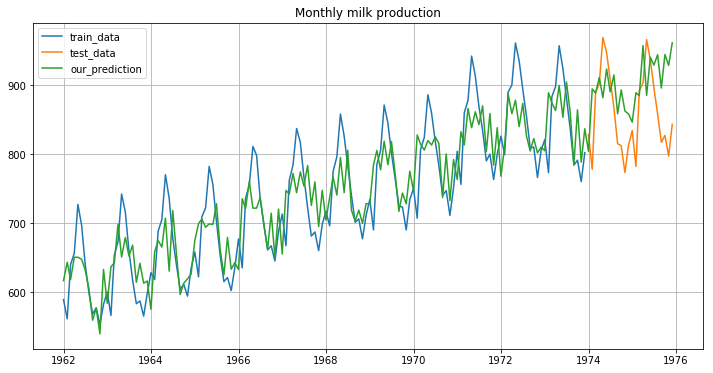

In [11]:
our_pred = predict_ours(train, all_data, yearly_seasonality=5, weekly_seasonality=5, seasonality_prior_scale_init=10)
show_result(all_data, train, test, our_pred, 'Monthly milk production', test_size)

{'rmse': 71.74021734275597,
 'mse': 5177.463376811079,
 'mae': 59.25894936645966,
 'rmsle': 0.08531116047576953,
 'mape': 5.578591775500328,
 'mdape': 5.141699558368161,
 'smape': 5.472302441693219,
 'smdape': 5.032633338032799,
 'rmpse': 7.062822938475271}

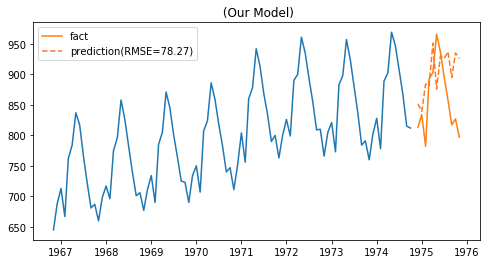

In [33]:
cv_pymodel(all_data, n_fold=3, test=0.5, offset=0.5, 
           yearly_seasonality=5, weekly_seasonality=5, seasonality_prior_scale_init=10, plot=True)

## AEP

In [15]:
data_aep = pd.read_csv('AEP_hourly.csv')
data_aep.columns = ['time', 'data']
aep = pd.DataFrame(data_aep, columns=['time', 'data']).set_index('time')
aep.sort_index(inplace=True)
aep = aep.iloc[105000:]
test_size=118
train_aep = aep.iloc[:-test_size, :]
test_aep = aep.iloc[-test_size:, :]
train_aep.index = pd.to_datetime(train_aep.index)
test_aep.index = pd.to_datetime(test_aep.index)
aep.index = pd.to_datetime(aep.index)

MSE, Test: 5429637.362581056
RMSE, Test: 2330.1582269410496
MAE, Test: 1857.5394665490408
RMSLE, Test: 0.16297910394867077
MAPE, Test: 13.729561339961643
MdAPE, Test: 9.48973475756851
sMAPE, Test: 12.467567640193087
sMdAPE, Test: 9.177130525700077
RMSPE, Test: 18.592309872093626


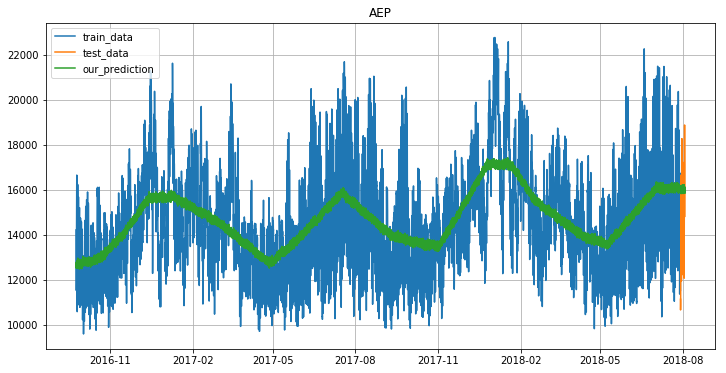

In [16]:
our_pred = predict_ours(train_aep, aep, yearly_seasonality=5, weekly_seasonality=10, seasonality_prior_scale_init=10)
show_result(aep, train_aep, test_aep, our_pred, 'AEP', test_size)

{'rmse': 2960.2734027536776,
 'mse': 9231276.58462823,
 'mae': 2590.447971434151,
 'rmsle': 0.1813912614073948,
 'mape': 15.754170765538609,
 'mdape': 15.704226535782922,
 'smape': 15.916457482978553,
 'smdape': 16.087214084626478,
 'rmpse': 18.029975903680324}

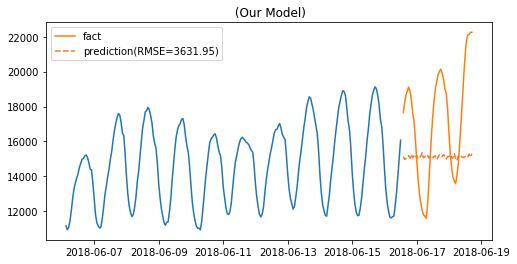

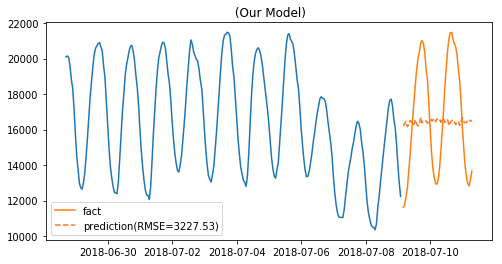

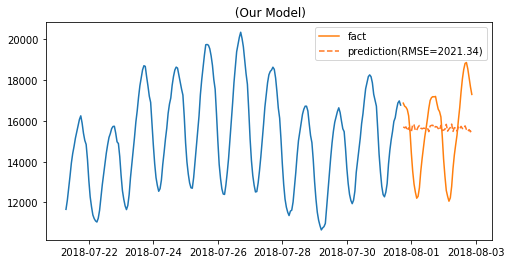

In [34]:
cv_pymodel(aep, n_fold=3, test=0.1, offset=0.9, 
           yearly_seasonality=5, weekly_seasonality=10, seasonality_prior_scale_init=10, plot=True)

## Weekly closings of the Dow-Jones industrial average, July 1971-August 1974

In [22]:
data_dj = pd.read_csv('DJ.csv', sep=';')
data_dj.columns = ['time', 'data']
data_dj['time'] = data_dj.reset_index().apply(lambda row: datetime.datetime.strptime(str(row['time']) + '-1', "%Y-W%W-%w"), axis=1)
dj = data_dj.set_index('time')

In [23]:
test_size = 14
train_dj = dj.iloc[:-14, :]
test_dj = dj.iloc[-14:, :]
train_dj.index = pd.to_datetime(train_dj.index)
test_dj.index = pd.to_datetime(test_dj.index)
dj.index = pd.to_datetime(dj.index)

MSE, Test: 1845.6507959183084
RMSE, Test: 42.96103811499797
MAE, Test: 34.81107491711279
RMSLE, Test: 0.05251206259771898
MAPE, Test: 2.9637167637833555
MdAPE, Test: 2.5429425695346315
sMAPE, Test: 2.8905196668909237
sMdAPE, Test: 2.5108211712116275
RMSPE, Test: 3.9028220763571904


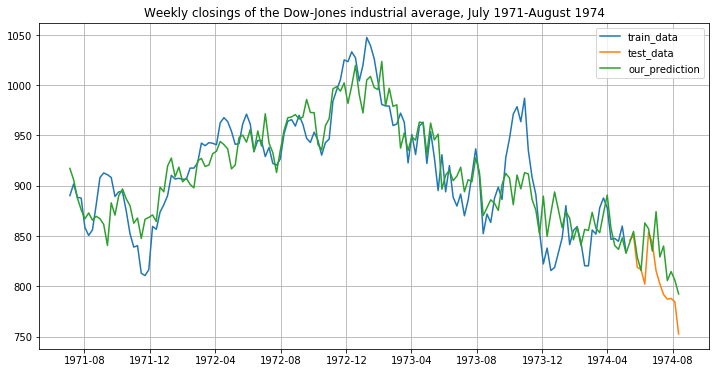

In [24]:
our_pred = predict_ours(train_dj, dj, yearly_seasonality=4, weekly_seasonality=15, seasonality_prior_scale_init=10, 
                        n_changepoints_init=20)
show_result(dj, train_dj, test_dj, our_pred, 
            'Weekly closings of the Dow-Jones industrial average, July 1971-August 1974', test_size)

{'rmse': 43.819470965414155,
 'mse': 2052.529726528735,
 'mae': 37.17443441361118,
 'rmsle': 0.049869158703421936,
 'mape': 4.002628087883156,
 'mdape': 4.167572155964539,
 'smape': 4.030007539160667,
 'smdape': 4.258511454256742,
 'rmpse': 4.781836977340382}

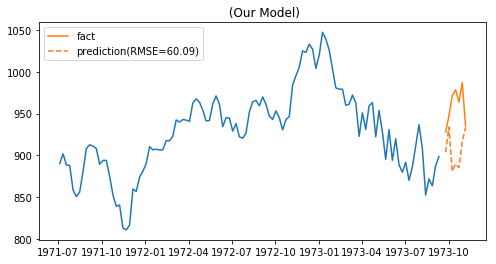

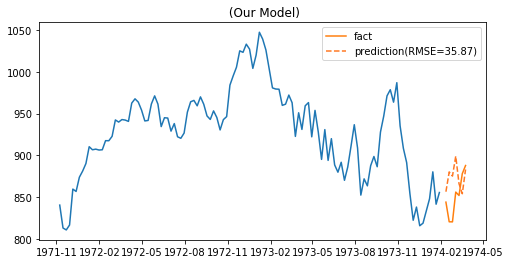

In [35]:
cv_pymodel(dj, n_fold=3, test=0.5, offset=0.65, 
           yearly_seasonality=4, weekly_seasonality=15, seasonality_prior_scale_init=10, n_changepoints_init=20, 
           plot=True)

## Monthly Australian Imports from Japan

In [27]:
au = pd.read_csv('import.csv', sep=';')
au.columns = ['time', 'data']
au = au.set_index('time')

In [28]:
test_size = 12
train_au = au.iloc[:-test_size, :]
test_au = au.iloc[-test_size:, :]

In [29]:
train_au.index = pd.to_datetime(train_au.index)
test_au.index = pd.to_datetime(test_au.index)
au.index = pd.to_datetime(au.index)

MSE, Test: 33173220996.09295
RMSE, Test: 182135.17232015607
MAE, Test: 143945.27706004374
RMSLE, Test: 0.18369183902731726
MAPE, Test: 13.390760987108774
MdAPE, Test: 12.227191538505108
sMAPE, Test: 14.486521577826775
sMdAPE, Test: 13.026634716269644
RMSPE, Test: 15.545928255461844


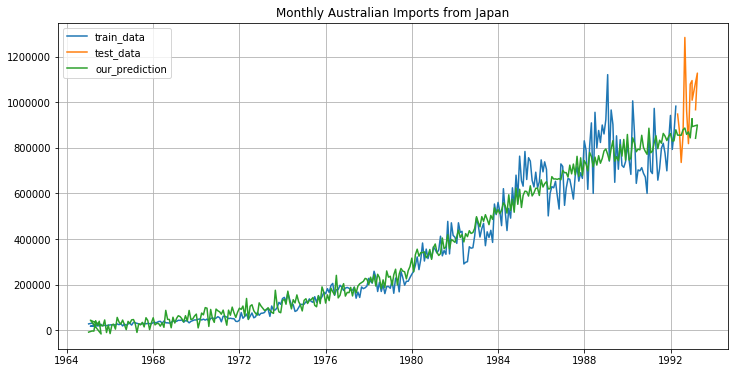

In [30]:
our_pred = predict_ours(train_au, au, yearly_seasonality=2, weekly_seasonality=20, seasonality_prior_scale_init=10, 
                        n_changepoints_init=20)
show_result(au, train_au, test_au, our_pred, 
            'Monthly Australian Imports from Japan', test_size)

{'rmse': 153139.05216888696,
 'mse': 23569541244.005325,
 'mae': 125328.71919636952,
 'rmsle': 0.18881363924109537,
 'mape': 16.142456858388126,
 'mdape': 14.52493735197846,
 'smape': 15.35975729704239,
 'smdape': 14.300881036798451,
 'rmpse': 19.00909380663982}

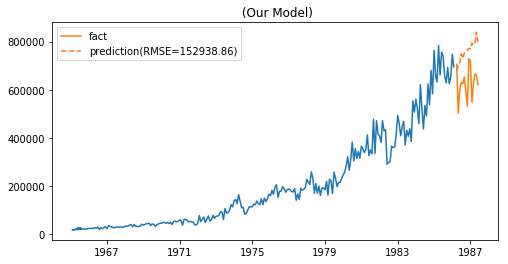

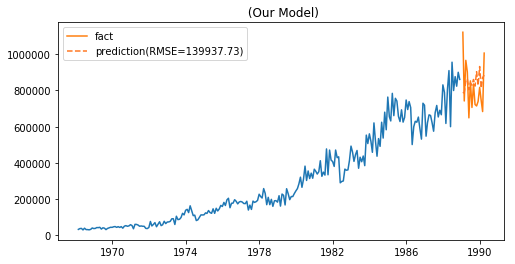

In [36]:
cv_pymodel(au, n_fold=3, test=0.5, offset=0.7, yearly_seasonality=2, weekly_seasonality=20, seasonality_prior_scale_init=10, 
                        n_changepoints_init=20, plot=True)